# Configure environment


In [ ]:
!nvidia-smi

Wed Nov  4 13:02:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
import numpy as np
import pandas as pd

In [9]:
running_type = 'C'
threads = 6

types = [{'name': 'S', 'max': 1, 'partitions': 1}, {'name': 'O', 'max': 16, 'partitions': 16}, {'name': 'C', 'max': 128 * 4, 'partitions': 20}]

for t in types:
    for threads in np.linspace(1, t['max'], t['partitions']):
        os.system("./bin/violajones {} {}".format(t['name'], threads))

In [ ]:
!cat output2.csv

1,1,303.596943
1,27,11.409342
1,54,5.934783
1,81,4.525623
1,108,4.058784
1,135,3.887120
1,162,3.900665
1,189,3.358987
1,216,3.473935
1,243,3.417205
1,269,3.619163
1,296,3.571559
1,323,3.528542
1,350,3.268446
1,377,3.264836
1,404,3.372774
1,431,3.413692
1,458,3.417488
1,485,3.373346
1,512,3.201726
10,1,30.575735
10,27,1.250428
10,54,0.699042
10,81,0.562368
10,108,0.518023
10,135,0.496419
10,162,0.503165
10,189,0.444854
10,216,0.457826
10,243,0.450773
10,269,0.472137
10,296,0.465450
10,323,0.462146
10,350,0.433650
10,377,0.436309
10,404,0.444526
10,431,0.456231
10,458,0.454969
10,485,0.453617
10,512,0.428530
19,1,16.146915
19,27,0.715309
19,54,0.429124
19,81,0.352349
19,108,0.328579
19,135,0.320794
19,162,0.319389
19,189,0.291558
19,216,0.301187
19,243,0.293284
19,269,0.305604
19,296,0.304380
19,323,0.299231
19,350,0.287916
19,377,0.290646
19,404,0.290163
19,431,0.295746
19,458,0.299920
19,485,0.293844
19,512,0.286874
28,1,10.993153
28,27,0.527542
28,54,0.332322
28,81,0.277869
28,108,0.2

In [ ]:
import pandas as pd
df = pd.read_csv("output2.csv", names=('MPs', "Threads", "Time"))

In [ ]:
sequential = df['Time'][0]
df["Speedup"] = df['Time'].apply(lambda x: sequential / x, 0)

In [ ]:
df[df['MPs'] == 1]

,MPs,Threads,Time,Speedup
0,1,1,303.596943,1
1,1,27,11.409342,26.6095
2,1,54,5.934783,51.1555
3,1,81,4.525623,67.084
4,1,108,4.058784,74.8
5,1,135,3.887120,78.1033
6,1,162,3.900665,77.8321
7,1,189,3.358987,90.3835
8,1,216,3.473935,87.3928
9,1,243,3.417205,88.8436


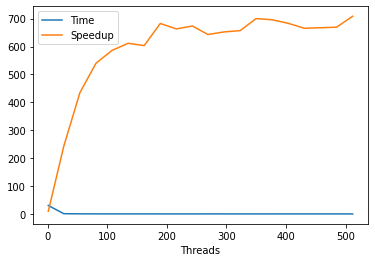

In [ ]:
#@title Blur effect

multiprocessors = 1 #@param {type:"slider", min:1, max:81, step:9}

df[df['MPs'] == multiprocessors][['Threads', "Time", "Speedup"]].plot(x="Threads")

In [ ]:
!ls /usr/local/cuda/bin/nvprof*

/usr/local/cuda/bin/bin2c
/usr/local/cuda/bin/computeprof
/usr/local/cuda/bin/cudafe
/usr/local/cuda/bin/cudafe++
/usr/local/cuda/bin/cuda-gdb
/usr/local/cuda/bin/cuda-gdbserver
/usr/local/cuda/bin/cuda-install-samples-8.0.sh
/usr/local/cuda/bin/cuda-memcheck
/usr/local/cuda/bin/cuobjdump
/usr/local/cuda/bin/fatbinary
/usr/local/cuda/bin/g++
/usr/local/cuda/bin/gcc
/usr/local/cuda/bin/gpu-library-advisor
/usr/local/cuda/bin/nsight
/usr/local/cuda/bin/nvcc
/usr/local/cuda/bin/nvcc.profile
/usr/local/cuda/bin/nvdisasm
/usr/local/cuda/bin/nvlink
/usr/local/cuda/bin/nvprof
/usr/local/cuda/bin/nvprune
/usr/local/cuda/bin/nvvp
/usr/local/cuda/bin/ptxas

/usr/local/cuda/bin/crt:
link.stub  prelink.stub


In [ ]:
!./bin/pi

In [ ]:
!tail output2.csv

82,431,0.243425
82,458,0.244504
82,485,0.251062
82,512,0.23940840,120,0.425272
40,120,0.320597
40,120,0.359431
40,120,0.357095
40,120,0.358252
40,120,0.343038
40,120,0.389715


In [ ]:
!nvprof -V

nvprof: NVIDIA (R) Cuda command line profiler
Copyright (c) 2012 - 2016 NVIDIA Corporation
Release version 8.0.61 (21)


In [ ]:
%%shell

/usr/local/cuda-10.0/bin/./nvprof ./bin/pi

==4433== NVPROF is profiling process 4433, command: ./bin/pi
==4433== Profiling application: ./bin/pi
==4433== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  240.74ms         1  240.74ms  240.74ms  240.74ms  calcPi(float*, long, long)
                    0.00%  6.3040us         1  6.3040us  6.3040us  6.3040us  red(float*)
                    0.00%  2.2080us         1  2.2080us  2.2080us  2.2080us  [CUDA memset]
                    0.00%  1.6000us         1  1.6000us  1.6000us  1.6000us  [CUDA memcpy DtoH]
      API calls:   54.81%  240.77ms         1  240.77ms  240.77ms  240.77ms  cudaMemcpy
                   44.96%  197.53ms         1  197.53ms  197.53ms  197.53ms  cudaMalloc
                    0.09%  412.48us         1  412.48us  412.48us  412.48us  cuDeviceTotalMem
                    0.05%  198.37us         1  198.37us  198.37us  198.37us  cudaFree
                    0.03%  148.90us        90  1.6540